# Demo for Anomaly Detection on the SKAB dataset using Randomized Signature as Features

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys
sys.path.append('../PenDigits/')
from RandomSignature import *
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from tsad.evaluating.evaluating import evaluating
import os
from tqdm.auto import tqdm
import utils

## Load and visualize the data 

              datetime  Accelerometer1RMS  Accelerometer2RMS   Current  \
0  2020-03-09 16:16:30           0.027545           0.041127  0.673506   
1  2020-03-09 16:16:31           0.027997           0.039100  0.772264   
2  2020-03-09 16:16:32           0.028418           0.038872  0.675520   
3  2020-03-09 16:16:33           0.027625           0.039366  0.566279   
4  2020-03-09 16:16:34           0.027484           0.041854  1.292170   

   Pressure  Temperature  Thermocouple  Voltage  Volume Flow RateRMS  anomaly  \
0  0.054711      67.8345       24.3164  240.513                 32.0      0.0   
1  0.054711      67.8704       24.3279  229.523                 32.0      0.0   
2  0.054711      67.7882       24.3261  242.708                 32.0      0.0   
3 -0.273216      67.7918       24.3323  229.709                 32.0      0.0   
4  0.054711      67.7368       24.3250  242.746                 32.0      0.0   

   changepoint  
0          0.0  
1          0.0  
2          0.0  


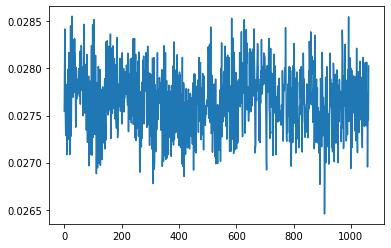

In [37]:
## read the data
list_of_df, anomaly_free = utils.read_SKAB(anomaly_free = True)

## inspect data
print(list_of_df[0].head())
cols = list_of_df[0].columns
#plot different columns of the dataset
plt.plot(list_of_df[0][cols[1]])





## Set hyperparameters

In [ ]:
## hyperparameters for the randomized signature and the model
def identity(x):
    return x
def sigmoid(x):
    return 1/(1+np.exp(-x))

hyperparams_dict = {
'varA':1e-5,
'mean':0,
'res_size':100,
'activation': identity
}

len_sub = 10
dim_paths = 8

[As,bs] = get_random_coeff(dim_paths,hyperparams_dict)


clf = IsolationForest(contamination = 0.1)
#clf = OneClassSVM(nu = 0.05)

## Train the model on the different datasets and compute predictions

In [38]:

anomalies = []
predictions = []


for df_test in tqdm(list_of_df):
        
    #save values for anomaly and changepoints
    anomalies_temp = df_test['anomaly'].to_list()#[400:]
    anomalies = anomalies + anomalies_temp

    
    df_test = df_test.drop(columns = ['datetime','anomaly','changepoint'])
    path = df_test.to_numpy()
    
    ## scaling (pre)
    path = sklearn.preprocessing.MinMaxScaler().fit_transform(path)
    

    #split in train and test and prepare the subsequences
    path_train = path[:400,:]
    path_test = path[400:,:]
    
    
    ## split into sub-series
    path_train = [path_train[len_sub*i:len_sub*(i+1),:] for i in range(int(path_train.shape[0]/len_sub+1))]
    #if the 400 or the time series is an exact multiple of len_sub then the last element in paths_train is [] 
    if len(path_train[-1])==0:
        path_train.pop()
    path_test = [path_test[len_sub*i:len_sub*(i+1),:] for i in range(int(path_test.shape[0]/len_sub+1))]
    if len(path_test[-1])==0:
        path_test.pop()   
    
    ## augmentations
    # basepoint
    path_train = [np.vstack((np.zeros_like(path[0,:]),path)) for path in path_train]
    path_test = [np.vstack((np.zeros_like(path[0,:]),path)) for path in path_test]
    
    ## scaling (post)
    #path_train = [sklearn.preprocessing.MinMaxScaler().fit_transform(path) for path in path_train]
    #path_test = [sklearn.preprocessing.MinMaxScaler().fit_transform(path) for path in path_test]

    
    ## compute the signature for train and test paths
    Sigs_train = [compute_signature(As,bs,path_train[i],False,hyperparams_dict) 
                     for i in range(len(path_train))]
    Sigs_test = [compute_signature(As,bs,path_test[i],False,hyperparams_dict) 
                     for i in range(len(path_test))]
    
    path = path_train+path_test
    Sigs = np.array(Sigs_train+Sigs_test)
    Sigs_train = np.array(Sigs_train)
    Sigs_test = np.array(Sigs_test)

    ## fit the model
    clf.fit(Sigs_train)
    
    # compute the predictions for each point
    pred_anomalies = []
    for i in range(Sigs.shape[0]):
        ## in np.ones() the -1 is needed because with the base point augmentation
        ## we make the sub-series one observation longer
        pred_anomalies = pred_anomalies + (-0.5*(clf.predict(Sigs)[i]-np.ones(path[i].shape[0]-1))).tolist()
    predictions = predictions + pred_anomalies


## Evaluate

In [39]:
FAR = (np.array(predictions)[np.array(anomalies) == 0] != np.array(anomalies)[np.array(anomalies) == 0]).sum()/np.array(anomalies)[np.array(anomalies) == 0].shape[0]
MAR = (np.array(predictions)[np.array(anomalies) == 1] != np.array(anomalies)[np.array(anomalies) == 1]).sum()/np.array(anomalies)[np.array(anomalies) == 1].shape[0]
F1 = sklearn.metrics.f1_score(anomalies,predictions)
print(F1,FAR,MAR)

0.6893963533368738 0.22363770855593 0.25491696640391825


## Evaluate on the anomaly-free run

False Alarm Rate on the normal run:  0.8766613503455609
False Alarm Rate on the first 1000 observations of the normal run:  0.16


<Figure size 432x288 with 0 Axes>

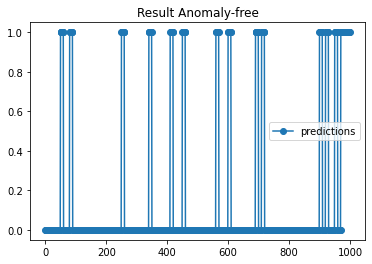

<Figure size 432x288 with 0 Axes>

In [41]:
## test on the normal run
#path_anomaly_free = 'data/anomaly-free/anomaly-free.csv'
#df = pd.read_csv(path_anomaly_free,sep = ';')
#df = df.drop(columns = ['datetime'])
#paths_free = df.to_numpy()
anomaly_free = sklearn.preprocessing.MinMaxScaler().fit_transform(anomaly_free)

#split in train and test
path_train = anomaly_free[:400,:]
path_test = anomaly_free[400:,:]

## splitting
path_train = [path_train[len_sub*i:len_sub*(i+1),:] for i in range(int(path_train.shape[0]/len_sub+1))]
#if the time series is an exact multiple of len_sub then the last element in paths_train is [] 
if len(path_train[-1])==0:
    path_train.pop()
path_test = [path_test[len_sub*i:len_sub*(i+1),:] for i in range(int(path_test.shape[0]/len_sub+1))]
if len(path_test[-1])==0:
    path_test.pop()    

## scaling
#path_train = [sklearn.preprocessing.MinMaxScaler().fit_transform(path) for path in path_train]    
#path_test = [sklearn.preprocessing.MinMaxScaler().fit_transform(path) for path in path_test]

## augmentations
# basepoint
path_train = [np.vstack((np.zeros_like(path[0,:]),path)) for path in path_train]
path_test = [np.vstack((np.zeros_like(path[0,:]),path)) for path in path_test]
    

Sigs_train = [compute_signature(As,bs,path_train[i],False,hyperparams_dict) 
                 for i in range(len(path_train))]
Sigs_test = [compute_signature(As,bs,path_test[i],False,hyperparams_dict) 
                 for i in range(len(path_test))]

path = path_train+path_test
Sigs = np.array(Sigs_train+Sigs_test)
Sigs_train = np.array(Sigs_train)
Sigs_test = np.array(Sigs_test)

#clf = IsolationForest(contamination = 0.1)
#clf = OneClassSVM(nu = 0.1)
clf.fit(Sigs_train)
pred = []
for i in range(Sigs.shape[0]):
        pred = pred + (-0.5*(clf.predict(Sigs)[i]-np.ones(path[i].shape[0]-1))).tolist()

#print('Performance on the test set (F1,FAR%,MAR%)', metrics_anomalies)
print('False Alarm Rate on the normal run: ', sum(pred)/len(pred))
print('False Alarm Rate on the first 1000 observations of the normal run: ', sum(pred[:1000])/1000)

## Plot the results for each dataset
plt.plot(pred[:1000],marker = 'o',label = 'predictions')
plt.legend()
plt.title('Result Anomaly-free')
plt.figure()